In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors

In [2]:
from rgc_natstim_model.utils.inference import get_model_responses
from rgc_natstim_model.utils.data_handling import convert_nested_dict_to_dataframe

In [3]:
from rgc_natstim_model.analyses.eval import calculate_correlations, calculate_nat_reliability_index

# Import constants

In [4]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids
from rgc_natstim_model.constants.paths import base_directory

# Set device

In [26]:
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"

# Assemble paths

In [5]:
dataset_hashes = list(dh2eh.keys())
ensemble_hashes = list(dh2eh.values())

file_name_template = r'2024-06-17_neuron_data_stim_c285329_responses_{}_wri.h5'
data_file_names = [file_name_template.format(dh[:7]) for dh in dataset_hashes]

data_file_names.pop()
data_file_names.append('2024-06-17_neuron_data_stim_41fc277_responses_5e62060_wri.h5')

model_type = 'nonlinear'

movie_file_name = '2024-01-11_movies_dict_c285329.pkl'
flipped_movie_file_name = '2024-05-27_movies_dict_41fc277.pkl'

## plot settings

In [6]:
rc_dict = {'figure.dpi': 300,
                     'figure.figsize': [2,2],
                     'figure.frameon': False,
                     'font.size': 8,
                     'lines.markersize':1,
                       'lines.markeredgewidth': .1,
                     'legend.columnspacing': .5,
                     'legend.frameon': False,
                     'legend.markerscale': .4,
                     'legend.labelspacing': 0.1,
                     'legend.handletextpad': 0,
                     'legend.loc': "lower right",
           'axes.labelpad': 1.0,
            'xtick.major.pad': 1, 'ytick.major.pad': 1,
                
                     }

# Loading

### movies

In [7]:
# load the movie 
movies_dict = pickle.load(open('/'.join([base_directory, 'data', 'movie', movie_file_name]), "rb"))

# load the movie file with the pre-flip-correction movie
movies_dict_flip = pickle.load(open('/'.join([base_directory, 'data', 'movie', flipped_movie_file_name]), "rb"))

### load all datasets

In [8]:
movie_data_dicts = {}
dataloaders_dict = {}
for dh, dfn in zip(dataset_hashes, data_file_names):
    data_path = os.path.join(base_directory, "data", 'base',dfn)
    responses = load_h5_into_dict(data_path)
    _movie_data_dict = make_final_responses(responses, response_type="natural") # upsampling
    if dh == '5e620609fc7b491aa5edb4a5d4cd7276':
        _dataloaders = natmov_dataloaders_v2(
        _movie_data_dict, movies_dict_flip, seed=1000
    )
    else:
        _dataloaders = natmov_dataloaders_v2(
            _movie_data_dict, movies_dict, seed=1000
        )
    movie_data_dicts.update({dh:_movie_data_dict})
    dataloaders_dict.update({dh:_dataloaders})

Loading HDF5 file contents:   0%|          | 0/385 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/11 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/11 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/175 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/5 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/5 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/140 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/4 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/4 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/700 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/20 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/20 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/210 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/6 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/6 [00:00<?, ?it/s]

Loading HDF5 file contents:   0%|          | 0/945 [00:00<?, ?item/s]

Upsampling natural traces to get final responses.:   0%|          | 0/27 [00:00<?, ?it/s]

Creating movie dataloaders:   0%|          | 0/27 [00:00<?, ?it/s]

In [9]:
# ToDo 
dh_2_session_ids = {k: list(v.keys()) for k, v in movie_data_dicts.items()}
session_ids_2_dhs = {_v: k for k, v in movie_data_dicts.items() for _v in list(v.keys())}
# remove empty session
session_ids_2_dhs.pop('session_1_ventral2_20200701')
dh_2_session_ids['5e620609fc7b491aa5edb4a5d4cd7276'].remove('session_1_ventral2_20200701')

dh_2_session_ids_renamed = {dh: ['_'.join(el.split('_')[1:]) for el in v] for dh, v in dh_2_session_ids.items()}

# Collect data in dataframe

In [10]:
df = convert_nested_dict_to_dataframe(movie_data_dicts)

# Predict test responses

### load model

In [11]:
def get_test_stim(dataloaders_dict, dataset_hash, session_id):
    return torch.unsqueeze(
        dataloaders_dict[dataset_hash]['test'][session_id].dataset.movies, 0
    ).cuda()


## CNN type model

In [12]:
prediction_dict = {}
corrs_dict = {}
corrs_to_avg_dict = {}
for dataset_hash in dataset_hashes:
    ensemble_hash = dh2eh[dataset_hash]
    model_path = os.path.join(base_directory, "models", 
                              model_type, ensemble_hash)
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(model_path, device=DEVICE);
    for session_id in dh_2_session_ids[dataset_hash]:
        # get model predictions for test stimulus
        test_movie_stim = get_test_stim(dataloaders_dict, dataset_hash, session_id)
        predictions = get_model_responses(
        ensemble_model, 
        test_movie_stim,  
        '_'.join(session_id.split('_')[1:])
       ).squeeze()

        current_neuron_ids = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['neuron_id'].values
        model_readout_idxs = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['model_readout_idx'].values
        [prediction_dict.update({_neuron_id:predictions[:, _model_readout_idx]})
         for _neuron_id, _model_readout_idx in zip(current_neuron_ids, model_readout_idxs)]

        # calculate correlation as metric of performance

        responses = dataloaders_dict[dataset_hash]['test'][session_id].dataset.test_responses_by_trial.numpy()
        corrs, corrs_to_avg = calculate_correlations(responses, predictions, 
                                                      resp_idxs=np.arange(len(current_neuron_ids)),
                                                      model_readout_idxs=model_readout_idxs
                                                     )

        corrs_dict.update(dict(zip(current_neuron_ids, corrs)))
        corrs_to_avg_dict.update(dict(zip(current_neuron_ids, corrs_to_avg)))
    del data_info
    del ensemble_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()


Random seed 0 has been set.


/gpfs01/euler/User/lhoefling/.local/lib/python3.11/site-packages/openretina/hoefling_2024/models.py:813: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  return mask.T


Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ig

In [13]:
df.insert(df.shape[1], 'corr_to_avg_recalc', 
          [corrs_to_avg_dict[neuron_id] for neuron_id in df.index])

df.insert(df.shape[1], 'single_trial_corr_recalc', 
          [corrs_dict[neuron_id].mean() for neuron_id in df.index])

df.insert(df.shape[1], 'test_prediction_recalc', [prediction_dict[neuron_id] for neuron_id in df.index])

## LN type model

In [14]:
prediction_dict = {}
corrs_dict = {}
corrs_to_avg_dict = {}
model_type = 'linear'
for dataset_hash in dataset_hashes:
    ensemble_hash = dh2eh_linear[dataset_hash]
    model_path = os.path.join(base_directory, "models", 
                              model_type, ensemble_hash)
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(model_path, device=DEVICE);
    for session_id in dh_2_session_ids[dataset_hash]:
        # get model predictions for test stimulus
        test_movie_stim = get_test_stim(dataloaders_dict, dataset_hash, session_id)
        predictions = get_model_responses(
        ensemble_model, 
        test_movie_stim, 
        '_'.join(session_id.split('_')[1:])
       ).squeeze()

        current_neuron_ids = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['neuron_id'].values
        model_readout_idxs = df[(df['dataset_hash']==dataset_hash)
        & (df['session_id']==session_id)]['model_readout_idx'].values
        [prediction_dict.update({_neuron_id:predictions[:, _model_readout_idx]})
         for _neuron_id, _model_readout_idx in zip(current_neuron_ids, model_readout_idxs)]

        # calculate correlation as metric of performance

        responses = dataloaders_dict[dataset_hash]['test'][session_id].dataset.test_responses_by_trial.numpy()
        corrs, corrs_to_avg = calculate_correlations(responses, predictions, 
                                                      resp_idxs=np.arange(len(current_neuron_ids)),
                                                      model_readout_idxs=model_readout_idxs
                                                     )

        corrs_dict.update(dict(zip(current_neuron_ids, corrs)))
        corrs_to_avg_dict.update(dict(zip(current_neuron_ids, corrs_to_avg)))
    del data_info
    del ensemble_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()


Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Rando

In [15]:
df.insert(df.shape[1], 'lin_corr_to_avg_recalc', 
          [corrs_to_avg_dict[neuron_id] for neuron_id in df.index])

df.insert(df.shape[1], 'lin_single_trial_corr_recalc', 
          [corrs_dict[neuron_id].mean() for neuron_id in df.index])

df.insert(df.shape[1], 'lin_test_prediction_recalc', [prediction_dict[neuron_id] for neuron_id in df.index])

# Insert additional columns to DF

In [16]:
df['movie_qis_recalc'] = df.apply(lambda x: calculate_nat_reliability_index(x), axis=1)

In [17]:
df['max_conf'] = df.apply(lambda row: row['group_confidences'][row['group_assignment']-1], axis=1)

In [18]:
#with open(os.path.join(base_directory, 'data', 'full_data_df.pkl'), 'wb') as f:
#    df.to_pickle(f)

# filter DF

In [19]:
restr_df = df[(df['max_conf']>=.25) & (df['group_assignment']<33)]

In [20]:
#with open(os.path.join(base_directory, 'data', 'restr_data_df.pkl'), 'wb') as f:
#    restr_df.to_pickle(f)

# plot predictions for example cells

## define hashes for example session

In [21]:
dataset_hash_current = '57ff42f31240ab511be30f98b4a07ffe'

ensemble_hash_current = dh2eh[dataset_hash_current]
print(ensemble_hash_current)

session_id_current = '2_ventral2_20201117'
neuron_id_current = '20201117_2_2_66_s_5'
print(session_id_current)

9d574ab9fcb85e8251639080c8d402b7
2_ventral2_20201117


Text(0.5, 1.02, 'Test movie responses\n and predictions')

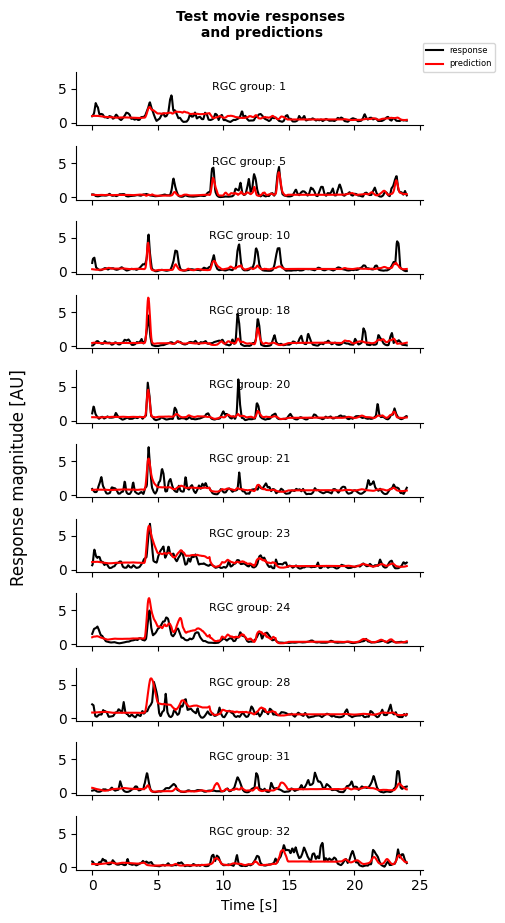

In [22]:
dataloaders_dict[dataset_hash_current]['test'][f'session_{session_id_current}'].dataset.responses
max_t = 720/30
time_axis = np.linspace(0, max_t, 720)
fig, axes = plt.subplots(len(example_nids), 1, figsize=(5, 9), sharex=True, sharey=True)
for i, (ax, (celltype, neuron_id)) in enumerate(zip(axes.ravel(), example_nids.items())):
    ax.plot(time_axis, df['test_response'].loc[neuron_id].mean(axis=0), color='k', label='response')
    ax.plot(time_axis, df['test_prediction_recalc'].loc[neuron_id], color='r', label='prediction')
    ax.set_title(f'RGC group: {celltype}', fontsize=8, y=.5)

axes[0].legend(fontsize=6, loc=(1,1))
ax.set_xlabel('Time [s]')
fig.supylabel('Response magnitude [AU]', x=0)
sns.despine()
plt.tight_layout()
plt.suptitle('Test movie responses\n and predictions', y=1.02, fontsize=10, fontweight='bold')

# plot corrs

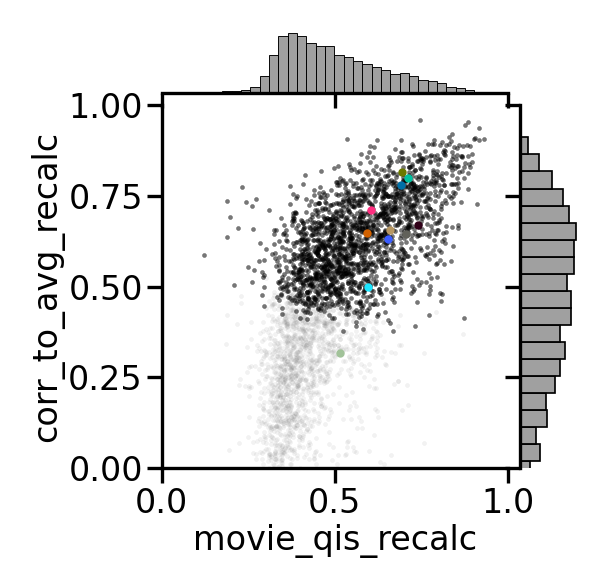

In [23]:
with mpl.rc_context(rc_dict):
    g = sns.jointplot(data=restr_df, x="movie_qis_recalc", y="corr_to_avg_recalc",
                    color="grey", edgecolor=None,
                      height=rc_dict["figure.figsize"][0],
                       alpha=.1, xlim=[0., 1], ylim=[0, 1]
                     )
    sns.scatterplot(data=restr_df[restr_df["single_trial_corr_recalc"]>.3], x="movie_qis_recalc", y="corr_to_avg_recalc",
                   color="k",edgecolor=None,
                      alpha=.5, ax=g.ax_joint
                    )
    for t, nid in example_nids.items():
        g.ax_joint.scatter(restr_df["movie_qis_recalc"].loc[nid], 
                           restr_df["corr_to_avg_recalc"].loc[nid],
                           color=rgc_colors[t-1],
                           
                           
                           )

In [24]:
temp_df = restr_df[restr_df['group_assignment']==t]
temp_df.shape

(446, 54)

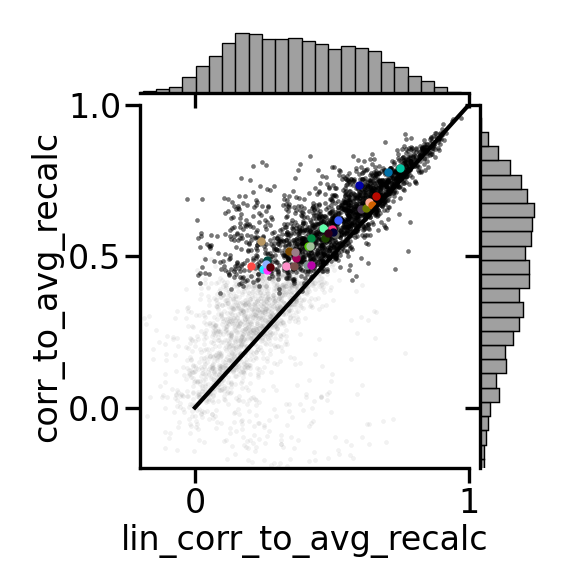

In [25]:
with mpl.rc_context(rc_dict):
    g = sns.jointplot(data=restr_df, x="lin_corr_to_avg_recalc", y="corr_to_avg_recalc",
                    color="grey", edgecolor=None,
                      height=rc_dict["figure.figsize"][0],
                       alpha=.1, xlim=[-.2, 1], ylim=[-.2, 1]
                     )
    sns.scatterplot(data=restr_df[restr_df["single_trial_corr_recalc"]>.3], 
                    x="lin_corr_to_avg_recalc", 
                    y="corr_to_avg_recalc",
                   color="k",edgecolor=None,
                      alpha=.5, ax=g.ax_joint
                    )
    g.ax_joint.plot([0,1], [0,1], color='k', linewidth=1)
    for t in range(1, 33):
        temp_df = restr_df[(restr_df['group_assignment']==t) & (restr_df["corr_to_avg_recalc"]>.3)]
        g.ax_joint.scatter(temp_df["lin_corr_to_avg_recalc"].mean(), 
                           temp_df["corr_to_avg_recalc"].mean(),
                           color=rgc_colors[t-1],#edgecolor="k"
                           )
